In [4]:
%load_ext autoreload
%autoreload 2
sys.path.append("..")   # fix to import modules from root
from src.general_imports import *
from src import modelling

import logging
logger = logging.getLogger('pymc')
logger.propagate = False
logger.setLevel(logging.ERROR)

N_SITES =  7

amdata = amdata.AnnMethylData('../exports/wave3_linear.h5ad')
amdata = amdata[amdata.sites.sort_values('r2', ascending=False).index[:N_SITES]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
# sort participants by age
amdata = amdata[:, np.argsort(amdata[0].participants.age)]

In [114]:
import pymc as pm
import arviz as az

In [180]:
def vect_linear_site(amdata):
    ages = np.broadcast_to(amdata.participants.age, shape=(amdata.n_sites, amdata.n_participants)).T
    coords = {'sites': amdata.sites.index.values,
            'participants': amdata.participants.index.values}


    with pm.Model(coords=coords) as model:

        # Define priors
        mean_slope = pm.Uniform("mean_slope", lower=-1/100, upper=1/100, dims='sites')
        mean_inter = pm.Uniform("mean_inter", lower=0, upper=1, dims='sites')
        var_inter = pm.Uniform("var_inter", lower=0, upper=1/10, dims='sites')
        
        # model mean and variance
        mean = mean_slope*ages + mean_inter
        variance = var_inter

        pm_data = pm.Data("data", amdata.X.T, dims=("participants", "sites"), mutable=True)

        # Define likelihood
        likelihood = pm.Normal("m-values",
            mu = mean,
            sigma = np.sqrt(variance),
            observed = pm_data)

        trace = pm.sample(cores=1, progressbar=True)
        max_p = pm.find_MAP(progressbar=True)

    return trace, max_p

def vect_chem_site(amdata):
    ages = np.broadcast_to(amdata.participants.age, shape=(amdata.n_sites, amdata.n_participants)).T
    coords = {'sites': amdata.sites.index.values,
            'participants': amdata.participants.index.values}
            
    with pm.Model(coords=coords) as model:

        # Define priors
        nu_0 = pm.Uniform("nu_0", lower=0, upper=0.1, dims='sites')
        nu_1 = pm.Uniform("nu_1", lower=0, upper=0.1, dims='sites')
        p = pm.Uniform("init_meth", lower=0, upper=1, dims='sites')
        var_init = pm.Uniform("var_init", lower=0, upper=1_000_000, dims='sites')
        N = pm.Uniform('system_size', lower= 10, upper=1_000_1000)


        # Useful variables
        omega = nu_0 + nu_1
        eta_0 = nu_0/omega
        eta_1 = nu_1/omega
        
        # model mean and variance
        var_term_0 = eta_0*eta_1
        var_term_1 = (1-p)*np.power(eta_0,2) + p*np.power(eta_1,2)

        mean = eta_0 + np.exp(-omega*ages)*((p-1)*eta_0 + p*eta_1)

        variance = (var_term_0/N 
                + np.exp(-omega*ages)*(var_term_1-var_term_0)/N 
                + np.exp(-2*omega*ages)*(var_init/np.power(N,2) - var_term_1/N)
            )

        # mean = eta_0 + np.exp(-omega*ages)*((p-1)*eta_0 + p*eta_1)

        # var_term_0 = eta_0*eta_1
        # var_term_1 = (1-p)*np.power(eta_0,2) + p*np.power(eta_1,2)


        # variance = (var_term_0/N 
        #         + np.exp(-omega*ages)*(var_term_1-var_term_0)/N 
        #         + np.exp(-2*omega*ages)*(var_init/np.power(N,2) - var_term_1/N)
        #     )
        pm_data = pm.Data("data", amdata.X.T, dims=("participants", "sites"), mutable=True)

        # Define likelihood
        likelihood = pm.Beta("m-values",
            mu = mean,
            sigma = np.sqrt(variance),
            observed = pm_data)

        trace = pm.sample(cores=4, progressbar=True)
        max_p = pm.find_MAP(progressbar=True)

    return trace, max_p

In [181]:
trace, max_p = vect_chem_site(amdata[1])

array([[<AxesSubplot: title={'center': 'nu_0'}>,
        <AxesSubplot: title={'center': 'nu_0'}>],
       [<AxesSubplot: title={'center': 'nu_1'}>,
        <AxesSubplot: title={'center': 'nu_1'}>],
       [<AxesSubplot: title={'center': 'init_meth'}>,
        <AxesSubplot: title={'center': 'init_meth'}>],
       [<AxesSubplot: title={'center': 'var_init'}>,
        <AxesSubplot: title={'center': 'var_init'}>],
       [<AxesSubplot: title={'center': 'system_size'}>,
        <AxesSubplot: title={'center': 'system_size'}>]], dtype=object)

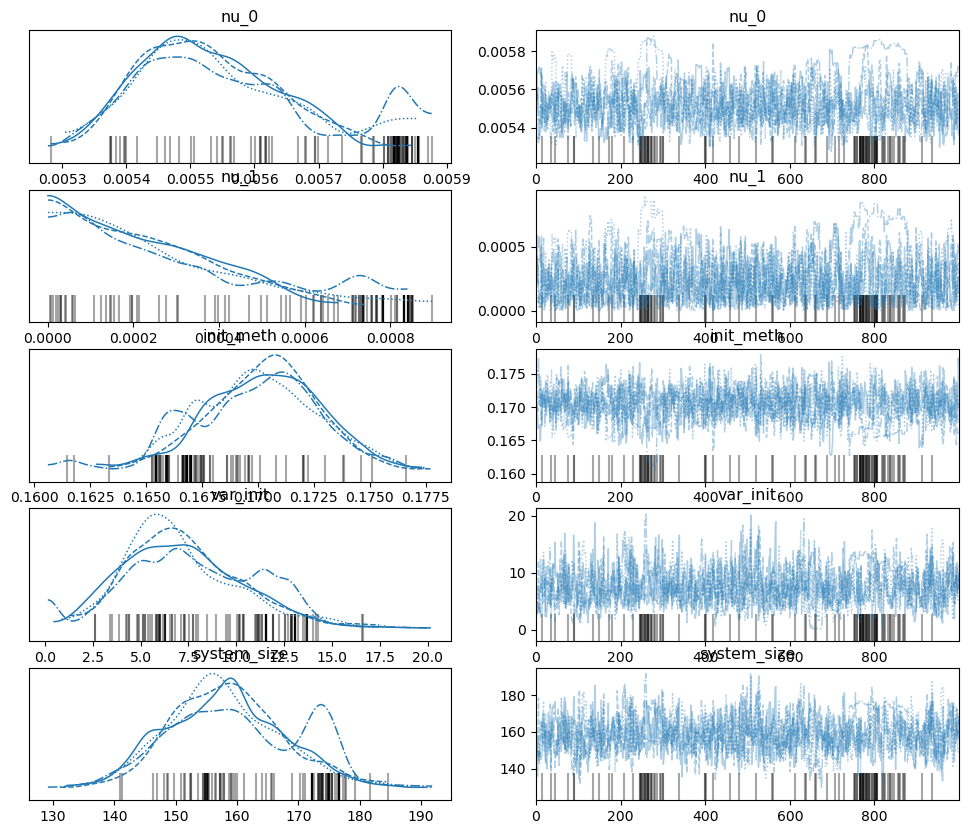

In [182]:
az.plot_trace(trace)

In [184]:
import matplotlib.pyplot as plt

In [189]:
trace_summary = az.summary(trace)

In [197]:
max_p = trace_summary['mean']

In [206]:
max_p.

nu_0[cg06639320]           0.006
nu_1[cg06639320]           0.000
init_meth[cg06639320]      0.170
var_init[cg06639320]       7.435
system_size              158.647
Name: mean, dtype: float64

(0.0, 1.0)

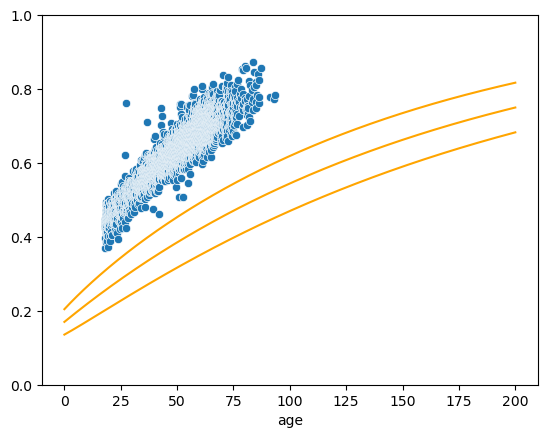

In [208]:
def chemical_plot (nu_0, nu_1, p, var_init, N, site=None):
  omega = nu_0 + nu_1
  eta_0 = nu_0/omega
  eta_1 = nu_1/omega

  t= np.linspace(0,200, 1_000)
  mean = eta_0 + np.exp(-omega*t)*((p-1)*eta_0 + p*eta_1)

  var_term_0 = eta_0*eta_1
  var_term_1 = (1-p)*np.power(eta_0,2) + p*np.power(eta_1,2)


  var = (var_term_0/N 
          + np.exp(-omega*t)*(var_term_1-var_term_0)/N 
          + np.exp(-2*omega*t)*(var_init/np.power(N,2) - var_term_1/N)
        )

  sns.lineplot(x=t, y=mean, color='orange')
  sns.lineplot(x=t, y=mean+2*np.sqrt(var), color='orange')
  sns.lineplot(x=t, y=mean-2*np.sqrt(var), color='orange')

  if site != None:
    sns.scatterplot(x=amdata[site].participants.age, y=amdata[site].X.flatten())
  # sns.lineplot(x=t, y=mean_linear, color='orange')
  # sns.lineplot(x=t, y=mean_linear+2*np.sqrt(var_linear), color='orange')
  # sns.lineplot(x=t, y=mean_linear-2*np.sqrt(var_linear), color='orange')


# params = [max_p['nu_0'], max_p['nu_1'], max_p['var_init'], max_p['init_meth'],  max_p['system_size']]

chemical_plot(*list(max_p), site=0)
plt.ylim(0,1)

In [146]:
def stochastic_chem(t, nu_0=0.01, nu_1=0.005, tmax=100, p=0.1, N=10_000, from_zero=False):
    ''' Stochastic B-D model of a clone.
    Parameters:
    - t: float. Start time
    - lamb: float. Birth rate (events/ year).
    - mu: float. Death (events/ year).
    - tmax: int age of individuals for stopping time
    - from_zero: Bool. Choose wether checkpoints are recorded from clone birth
                       or from time 0.
    Returns:
    - checkpoints: Array. Recorded population of cells every year.
    '''
    # initialise cells
    meth_cells = p*N

    if from_zero is False:
        # compute first recorded time_point
        t0 = int(np.ceil(t))
        # create checkpoints array
        checkpoints = np.zeros((2, int(tmax)-t0+1))
        checkpoints[0] = np.linspace(t0, int(tmax),
                                     int(tmax)-t0+1)

        # Append initial population if start time is a checkpoint.
        if t == t0:
            checkpoints[1, 0] = meth_cells

    if from_zero is True:
        t0 = int(0)
        # create checkpoints array starting at 0
        checkpoints = np.zeros((2, int(tmax)+1))
        checkpoints[0] = np.linspace(t0, int(tmax),
                                     int(tmax)+1)

        if int(t) == t:
            checkpoints[1, t] = meth_cells

    # model loop
    while t <= tmax:
        # save current time in previous_t
        previous_t = t

        # update birth and death rates
        meth_propensity = nu_0 * (N-meth_cells)
        unmeth_propensity = nu_1 * meth_cells

        #  Timestep to next event
        rate = meth_propensity + unmeth_propensity
        t += -np.log(np.random.uniform(0, 1)) / rate

        # Check if any timepoints occurred between t_previous and t.
        # If so append x for all such timepoints
        checkpoints[1, int(previous_t)-t0+1:int(t)-t0+1] = meth_cells

        # Decision of which event happened during time-step
        urv = np.random.uniform(0, 1)
        if urv >= meth_propensity / rate:
            meth_cells -= 1

        else:
            meth_cells += 1

    checkpoints = checkpoints/N
    return checkpoints


In [155]:
from scipy.stats import norm

In [158]:
total = []
for i in range(100):
    total.append(stochastic_chem(0, p=norm.rvs(loc=0.1, scale=0.01)))

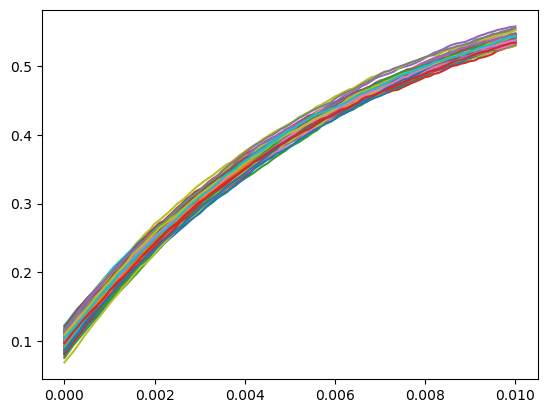

In [159]:
for checkpoints in total:
    sns.lineplot(x=checkpoints[0], y=checkpoints[1])

In [134]:
def chemical_plot (nu_0, nu_1, var_init, p, N, site=None):
  omega = nu_0 + nu_1
  eta_0 = nu_0/omega
  eta_1 = nu_1/omega

  t= np.linspace(0,200, 1_000)
  mean = eta_0 + np.exp(-omega*t)*((p-1)*eta_0 + p*eta_1)

  var_term_0 = eta_0*eta_1
  var_term_1 = (1-p)*np.power(eta_0,2) + p*np.power(eta_1,2)


  var = (var_term_0/N 
          + np.exp(-omega*t)*(var_term_1-var_term_0)/N 
          + np.exp(-2*omega*t)*(var_init/np.power(N,2) - var_term_1/N)
        )

  # mean_linear = eta_0 + (1-omega*t)*((p-1)*eta_0 + p*eta_1)
  # var_linear = (var_term_0/N 
  #         + (1-omega*t)*(var_term_1-var_term_0)/N 
  #         + ((1-omega*t)**2)*(var_init/np.power(N,2) - var_term_1/N)
  #       )

  sns.lineplot(x=t, y=mean, color='orange')
  sns.lineplot(x=t, y=mean+2*np.sqrt(var), color='orange')
  sns.lineplot(x=t, y=mean-2*np.sqrt(var), color='orange')

  if site != None:
    sns.scatterplot(x=amdata[site].participants.age, y=amdata[site].X.flatten())
  # sns.lineplot(x=t, y=mean_linear, color='orange')
  # sns.lineplot(x=t, y=mean_linear+2*np.sqrt(var_linear), color='orange')
  # sns.lineplot(x=t, y=mean_linear-2*np.sqrt(var_linear), color='orange')

array([<AxesSubplot: title={'center': 'nu_0\ncg06639320'}>,
       <AxesSubplot: title={'center': 'nu_1\ncg06639320'}>,
       <AxesSubplot: title={'center': 'init_meth\ncg06639320'}>,
       <AxesSubplot: title={'center': 'var_init\ncg06639320'}>],
      dtype=object)

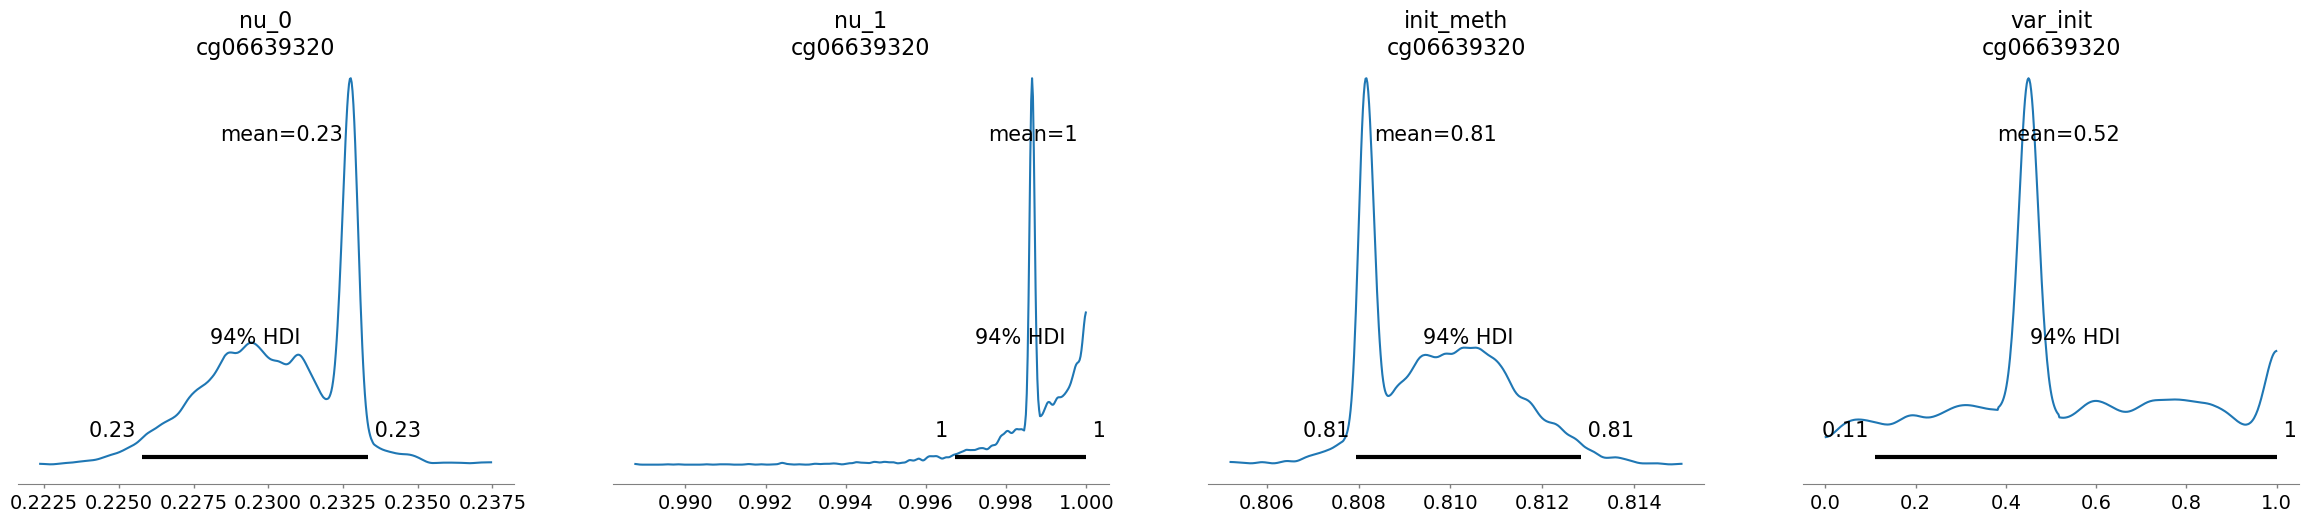

In [9]:
az.plot_posterior(trace)

In [10]:
trace, max_p = vect_linear_site(amdata[0])

array([[<AxesSubplot: title={'center': 'mean_slope'}>,
        <AxesSubplot: title={'center': 'mean_slope'}>],
       [<AxesSubplot: title={'center': 'mean_inter'}>,
        <AxesSubplot: title={'center': 'mean_inter'}>],
       [<AxesSubplot: title={'center': 'var_inter'}>,
        <AxesSubplot: title={'center': 'var_inter'}>]], dtype=object)

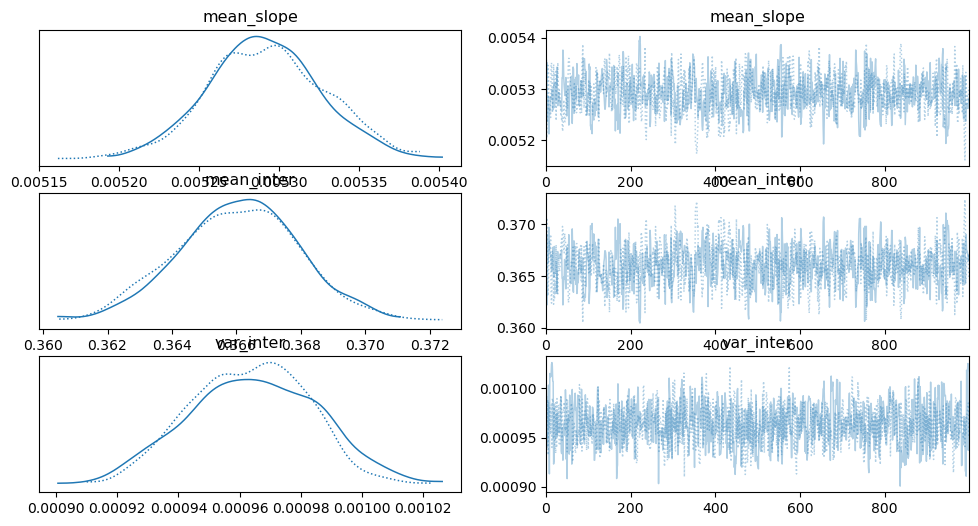

In [13]:
az.plot_trace(trace)

In [10]:
with Pool(N_SITES, maxtasksperchild=1) as p:
    results = list(tqdm(
            iterable= p.imap(
                func=modelling.fit_and_compare,
                iterable=[amdata[i] for i in amdata.obs.index], 
                ), 
            total=amdata.n_obs))

def comparison_postprocess(results, amdata):
    fits = pd.DataFrame()
    comparisons = pd.DataFrame()
    for site in results:
        fit, comparison = site
        fits = pd.concat([fits, fit])
        comparisons = pd.concat([comparisons, comparison])

    amdata.obs['mean_slope'] = fits.loc[(slice(None),'drift','mean_slope')].MAP.values
    amdata.obs['mean_inter'] = fits.loc[(slice(None),'drift','mean_inter')].MAP.values
    amdata.obs['var_slope'] = fits.loc[(slice(None),'drift','var_slope')].MAP.values
    amdata.obs['var_inter'] = fits.loc[(slice(None),'drift','var_inter')].MAP.values


  0%|          | 0/7 [00:00<?, ?it/s]/home/elatorre/anaconda3/envs/NSEA_env/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
100%|██████████| 7/7 [02:18<00:00, 19.72s/it] 


In [18]:
fits = pd.DataFrame()
comparisons = pd.DataFrame()
for site in results:
    fit, comparison = site
    fits = pd.concat([fits, fit])
    comparisons = pd.concat([comparisons, comparison])

amdata.obs['mean_slope'] = fits.loc[(slice(None),'drift','mean_slope')]['mean'].values
amdata.obs['mean_inter'] = fits.loc[(slice(None),'drift','mean_inter')]['mean'].values
amdata.obs['var_slope'] = fits.loc[(slice(None),'drift','var_slope')]['mean'].values
amdata.obs['var_inter'] = fits.loc[(slice(None),'drift','var_inter')]['mean'].values

In [19]:
amdata.obs

,pos,Hannum,Horvath,PhenoAge,SnB,Weidner,r2,mean_slope,mean_inter,var_slope,var_inter
cg16867657,111488,True,False,False,True,False,0.835386,0.005349,0.363090,0.000006,0.000659
cg06639320,716944,True,False,False,True,False,0.650581,0.003485,0.191647,0.000012,0.000499
cg21572722,565494,False,False,False,True,False,0.650086,0.002208,0.221390,0.000001,0.000394
cg17268658,607750,False,False,False,False,False,0.649949,0.003039,0.231452,0.000006,0.000563
cg22454769,119241,True,False,False,True,False,0.649359,0.004398,0.319058,0.000010,0.001244
cg24724428,49403,False,False,False,False,False,0.631854,0.003213,0.065362,0.000020,0.000030
cg10501210,84198,True,False,False,True,False,0.611938,-0.006131,0.999578,0.000089,0.000089


In [22]:
from scipy.stats import norm

In [30]:
site.obs.mean_slope[0]

0.0053493

cg16867657    0.005349
Name: mean_slope, dtype: float64

In [60]:
conf_int[0]

array([0.36148035, 0.36682246, 0.37216461, 0.37750678, 0.38284898,
       0.38819122, 0.39353348, 0.39887578, 0.4042181 , 0.40956046,
       0.41490284, 0.42024525, 0.42558769, 0.43093015, 0.43627265,
       0.44161517, 0.44695772, 0.45230029, 0.45764289, 0.46298552,
       0.46832817, 0.47367084, 0.47901354, 0.48435627, 0.48969902,
       0.49504179, 0.50038459, 0.50572741, 0.51107026, 0.51641313,
       0.52175602, 0.52709893, 0.53244187, 0.53778482, 0.5431278 ,
       0.54847081, 0.55381383, 0.55915687, 0.56449994, 0.56984302,
       0.57518613, 0.58052926, 0.5858724 , 0.59121557, 0.59655876,
       0.60190196, 0.60724519, 0.61258843, 0.6179317 , 0.62327498,
       0.62861828, 0.6339616 , 0.63930494, 0.6446483 , 0.64999167,
       0.65533507, 0.66067848, 0.6660219 , 0.67136535, 0.67670881,
       0.68205229, 0.68739579, 0.6927393 , 0.69808283, 0.70342638,
       0.70876994, 0.71411352, 0.71945711, 0.72480072, 0.73014435,
       0.73548799, 0.74083165, 0.74617532, 0.75151901, 0.75686

In [78]:
amdata['cg16867657']

View of AnnData object with n_obs × n_vars = 1 × 4450
    obs: 'pos', 'Hannum', 'Horvath', 'PhenoAge', 'SnB', 'Weidner', 'r2', 'mean_slope', 'mean_inter', 'var_slope', 'var_inter'
    var: 'pos', 'name', 'age', 'sex', 'units', 'usual', 'ever_smoke', 'pack_years', 'bmi', 'body_fat', 'simd', 'edu_years', 'Event', 'tte', 'Hannum', 'Horvath', 'Grim', 'Pheno'

In [85]:
def plot_drift(amdata, site):
    """Plot the predicted evolution of
    methylation according to drift model.
    
    Parameters:
    site: str or int. Name of cpg site or index value"""

    x_space = np.arange(0, 100)
    site = amdata[site]
    mean = x_space*site.obs.mean_slope[0] + site.obs.mean_inter[0]
    var = x_space*site.obs.var_slope[0] + site.obs.var_inter[0]

    conf_int = norm.interval(0.95, mean, np.sqrt(var))

    sns.scatterplot(x=site.var.age, y=site.X.flatten())
    sns.lineplot(x=x_space, y = mean, color='green')
    sns.lineplot(x=x_space, y = conf_int[0], color='orange')
    sns.lineplot(x=x_space, y = conf_int[1], color='orange')

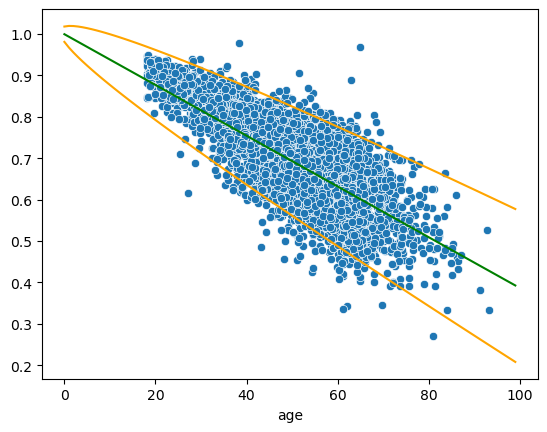

In [90]:
plot_drift(6)

In [ ]:
comparison_postprocess(results, amdata)